# Домашняя работа 1


In [1]:
from ogb.nodeproppred import NodePropPredDataset
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

1. Загрузка данных

In [2]:
import warnings

warnings.filterwarnings('ignore')

dataset = NodePropPredDataset(name='ogbn-arxiv', root='data')
graph, labels = dataset[0]

print("Количество узлов:", graph["num_nodes"])
print("Количество рёбер:", graph["edge_index"].shape[1])

Количество узлов: 169343
Количество рёбер: 1166243


In [3]:
edge_index = graph["edge_index"].T  # np.array (1.1M × 2)
G = nx.DiGraph()
G.add_edges_from(edge_index)
G = G.to_undirected()

Визуализируйте граф на семпле из 1000 узлов

In [4]:
import random

random.seed(42)
np.random.seed(42)

all_nodes = list(G.nodes)
sample_size = 1000
sample_nodes = np.random.choice(all_nodes, size=sample_size, replace=False)

H = G.subgraph(sample_nodes).copy()
print("Число узлов в подграфе ", H.number_of_nodes())
print("Число ребер в подграфе ", H.number_of_edges())

Число узлов в подграфе  1000
Число ребер в подграфе  34


In [5]:
pos = nx.spring_layout(H, k=0.1, iterations=50, seed=42)

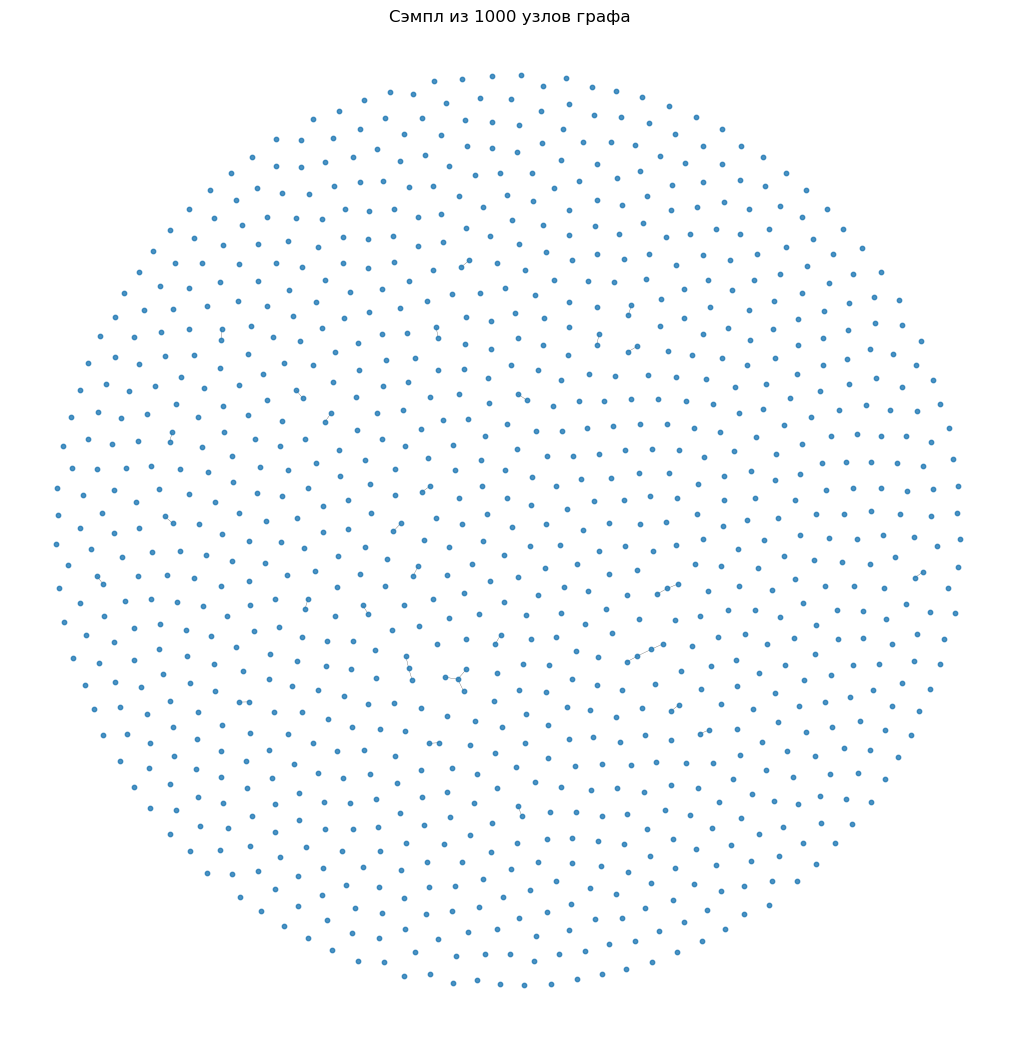

In [6]:
plt.figure(figsize=(10, 10))
nx.draw(
    H, pos,
    node_size=10,
    width=0.2,
    alpha=0.8,
    with_labels=False
)
plt.title("Сэмпл из 1000 узлов графа")
plt.axis('off')
plt.show()

### Предварительный анализ

Произведем предварительный анализ графа

Посчитаем на сэмле из 1000 вершин, тк на графе G считалось очень долго, для графа G посчитала среднюю степень, плотность и аппроксимированное значение диаметра

In [7]:
avg_degree_G = 2 * G.number_of_edges() / G.number_of_nodes()
print(f"Средняя степень G: {avg_degree_G:.2f}")

density_G = nx.density(G)
print(f"Плотность G: {density_G:.6f}")

diameter_G = nx.approximation.diameter(G)
print(f"Аппроксимированный диаметр графа G: {diameter_G:.4f}")

Средняя степень G: 13.67
Плотность G: 0.000081
Аппроксимированный диаметр графа G: 25.0000


Теперь для сэмпла, у нас подграф H несвязный, видно по визуализации, поэтому для корректной работы нужно выделить наибольшую компоненту связности и считать значения радиуса и диаметра для нее

In [8]:
avg_degree = 2 * H.number_of_edges() / H.number_of_nodes()
print(f"Средняя степень H: {avg_degree:.2f}")

density = nx.density(H)
print(f"Плотность H: {density:.6f}")

Средняя степень H: 0.07
Плотность H: 0.000068


In [9]:
import networkx as nx

print("В H узлов:", H.number_of_nodes())
print("В H рёбер:", H.number_of_edges())

# Находим все компоненты связности
components = list(nx.connected_components(H))
print("Число компонент связности в H:", len(components))

# Берём крупнейшую компоненту
largest_cc_nodes = max(components, key=len)
H_lcc = H.subgraph(largest_cc_nodes).copy()

print("Размер крупнейшей компоненты:", H_lcc.number_of_nodes())
print("Число рёбер в крупнейшей компоненте:", H_lcc.number_of_edges())
print("Связен ли H_lcc?", nx.is_connected(H_lcc))

В H узлов: 1000
В H рёбер: 34
Число компонент связности в H: 966
Размер крупнейшей компоненты: 4
Число рёбер в крупнейшей компоненте: 3
Связен ли H_lcc? True


In [10]:
# Считаем диаметр и радиус для крупнейшей компоненты
diameter = nx.diameter(H_lcc)
print(f"Диаметр графа H: {diameter:.4f}")

radius = nx.radius(H_lcc)
print(f"Радиус графа H: {radius:.4f}")

Диаметр графа H: 3.0000
Радиус графа H: 2.0000


Кажется, что этот результат не дает точной картины, попробуем посмотреть на сам граф G, сколько у него компонент связности

Сделаем то же самое для G

In [11]:
print("В G узлов:", G.number_of_nodes())
print("В G рёбер:", G.number_of_edges())

# Находим все компоненты связности
components_G = list(nx.connected_components(G))
print("Число компонент связности в G:", len(components_G))

# Берём крупнейшую компоненту
largest_cc_nodes_G = max(components_G, key=len)
G_lcc = G.subgraph(largest_cc_nodes_G).copy()

print("Размер крупнейшей компоненты:", G_lcc.number_of_nodes())
print("Число рёбер в крупнейшей компоненте:", G_lcc.number_of_edges())
print("Связен ли G_lcc?", nx.is_connected(G_lcc))

В G узлов: 169343
В G рёбер: 1157799
Число компонент связности в G: 1
Размер крупнейшей компоненты: 169343
Число рёбер в крупнейшей компоненте: 1157799
Связен ли G_lcc? True


Видно, что граф G является связным, поэтому кажется, что наиболее логичное решение - взять сэмпл из 1000 узлов, но убедиться, что это будет связный подграф (назвала его K), в таком случае можно будет посчитать радиус и диаметр

In [12]:
import random
from collections import deque
import networkx as nx

# Выбираем случайный стартовый узел в G
start = random.choice(list(G.nodes()))
print("Стартовый узел для BFS:", start)

# BFS, пока не наберём 1000 узлов
target_size = 1000
visited = {start}
queue = deque([start])

while queue and len(visited) < target_size:
    v = queue.popleft()
    for u in G[v]:
        if u not in visited:
            visited.add(u)
            queue.append(u)
            if len(visited) >= target_size:
                break

print("Сколько узлов набрали BFS:", len(visited))

# Строим связный подграф на этих 1000 узлах (или меньше, если компонентa маленькая)
K = G.subgraph(visited).copy()

print("Узлов в K:", K.number_of_nodes())
print("Рёбер в K:", K.number_of_edges())
print("Связен ли K?", nx.is_connected(K))

Стартовый узел для BFS: 140381
Сколько узлов набрали BFS: 1000
Узлов в K: 1000
Рёбер в K: 3902
Связен ли K? True


In [13]:
# Считаем диаметр и радиус для крупнейшей компоненты
diameter_K = nx.diameter(K)
print(f"Диаметр графа K: {diameter_K:.4f}")

radius_K = nx.radius(K)
print(f"Радиус графа K: {radius_K:.4f}")

Диаметр графа K: 5.0000
Радиус графа K: 3.0000


### Анализ на центральность

Найдите узел с максимальной центральностью

Считаю центральность для связного подграфа K, который является подграфом графа G с 1000 узлами, тк для графа G код работал слишком долго

In [22]:
degree_centrality = nx.degree_centrality(K)
top_deg = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:1]
print("Узел с максимальной degree centrality для подграфа K:")
for node, cent in top_deg:
    print(f"node={node}, centrality={cent:.5f}")

closeness_centrality = nx.closeness_centrality(K)
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:1]
print("Узел с максимальной closeness centrality:")
for node, cent in top_closeness:
    print(f"node={node}, centrality={cent:.5f}")

betweenness_centrality = nx.betweenness_centrality(K)
top_betw = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:1]
print("Узел с максимальной betweenness centrality:")
for node, cent in top_betw:
    print(f"node={node}, centrality={cent:.5f}")

Узел с максимальной degree centrality для подграфа K:
node=27824, centrality=0.16316
Узел с максимальной closeness centrality:
node=27824, centrality=0.52857
Узел с максимальной betweenness centrality:
node=27824, centrality=0.62273


Анализ кластеров

In [23]:
global_cluster_coeff = nx.average_clustering(G)
print("Cредний кластерный коэффициент графа:", global_cluster_coeff)

Cредний кластерный коэффициент графа: 0.22612914062470996


In [24]:
transitivity_coeff = nx.transitivity(G)
print("Коэффициент транзитивности графа:", transitivity_coeff)

Коэффициент транзитивности графа: 0.01620149151351999


### Поиск сообществ

Реализуйте 2 метода поиска сообществ:
1. С помощью готовой реализации в библиотеке NetworkX
2. Реализуйте самостоятельно класс с алгоритмом Clauset–Newman–Moore

Сравните полученные результаты

Алгоритм Clauset–Newman–Moore (CNM)

---

**1. Начальное состояние**
- Каждая вершина — отдельное сообщество.
- Вычисляем степени вершин и матрицу смежности.

---

**2. Вычисляем для всех пар сообществ** $(r, s)$, между которыми есть хотя бы одно ребро:

$$
\Delta Q_{rs} = 2 \, (e_{rs} - a_r a_s)
$$

где:

- $e_{rs}$ — доля рёбер между сообществами *r* и *s*, делённая на $2m$;
- $a_r = \sum_t e_{rt}$ — доля концов рёбер, инцидентных *r*.

---

**2.1. Доля концов рёбер, инцидентных вершинам из $r$**

Это часть всех концов рёбер в графе, которые принадлежат вершинам, входящим в сообщество $r$.

Эта величина обозначается как $a_r$ и вычисляется по формуле:

$$
a_r = \frac{1}{2m} \sum_{i \in r} k_i
$$

где:

- $k_i$ — степень вершины $i$ (сколько у неё рёбер);
- $m$ — общее число рёбер в графе;
- $2m$ — общее количество **концов рёбер** (так как каждое ребро имеет два конца).

---

**3. Выбираем пару $(r, s)$** с максимальным $\Delta Q$ и объединяем их.

---

**4. Обновляем:**
- значения $e_{rt}, a_r$;
- новую модульность:
  $$
  Q \leftarrow Q + \Delta Q
  $$

---

**5. Повторяем**, пока $\Delta Q > 0$.

---

**6. Выбираем состояние с максимальным $Q$** как оптимальное разбиение.


Описание алгоритма - https://arxiv.org/pdf/cond-mat/0408187

In [25]:
from collections import defaultdict


class CNM:
    """
    Алгоритм Clauset–Newman–Moore для обнаружения сообществ.
    Реализован для неориентированного (взвешенного) графа.
    edges: список троек (u, v, w).
    """

    def __init__(self, edges):
        self.graph = defaultdict(dict)
        for u, v, w in edges:
            if u == v:
                continue
            # делаем граф неориентированным
            self.graph[u][v] = self.graph[u].get(v, 0) + w
            self.graph[v][u] = self.graph[v].get(u, 0) + w

        self.nodes = list(self.graph.keys())
        # m = суммарный вес рёбер (каждое ребро считается один раз)
        self.m = sum(sum(self.graph[u].values()) for u in self.nodes) / 2.0
        self.deg = {u: sum(self.graph[u].values()) for u in self.nodes}

    def fit(self, verbose=False):
        # каждую вершину кладём в своё сообщество
        communities = {u: {u} for u in self.nodes}  # id_сообщества -> множество вершин
        comm_id = {u: u for u in self.nodes}  # вершина -> id_сообщества

        m2 = 2.0 * self.m

        # a_r = доля концов рёбер, инцидентных сообществу r
        a = {u: self.deg[u] / m2 for u in self.nodes}

        # Доля рёбер между сообществами e[r][s]
        # e_rs = (вес рёбер между r и s) / (2m)
        e = defaultdict(dict)  # e[r][s] = e_rs

        for u in self.nodes:
            for v, w in self.graph[u].items():
                if u < v:  # чтобы не считать каждое ребро дважды
                    cu, cv = comm_id[u], comm_id[v]
                    val = w / m2
                    e[cu][cv] = e[cu].get(cv, 0.0) + val
                    e[cv][cu] = e[cv].get(cu, 0.0) + val

        # Начальная модульность: Q = sum_r (e_rr - a_r^2), но e_rr = 0
        Q = -sum(a[c] ** 2 for c in a)

        if verbose:
            print(f"Initial Q = {Q:.6f}, communities = {len(communities)}")

        # Основной цикл
        while True:
            best_dQ = 0.0
            best_pair = None

            # Найти пару (r, s) с максимальным ΔQ
            # ΔQ_rs = 2 * (e_rs - a_r * a_s)
            for r in list(e.keys()):
                for s, e_rs in e[r].items():
                    if r >= s:
                        continue  # пары без повторов (r < s)
                    dQ = 2.0 * (e_rs - a[r] * a[s])
                    if dQ > best_dQ:
                        best_dQ = dQ
                        best_pair = (r, s)

            # Условие выхода
            if best_pair is None or best_dQ <= 0.0:
                if verbose:
                    print("ΔQ <= 0, останавливаемся")
                break

            r, s = best_pair
            if verbose:
                print(f"Объединяем {r} и {s} с ΔQ = {best_dQ:.6f}")

            # Объединение сообществ
            # сольём s в r
            communities[r] |= communities[s]
            for node in communities[s]:
                comm_id[node] = r
            communities[s].clear()

            # Обновление a, e, Q

            # обновляем a_r = a_r + a_s, удаляем a_s
            a[r] = a[r] + a[s]
            a.pop(s, None)

            # обновляем e: для каждого t, соседнего с r или s,
            # e_{rt}^{new} = e_{rt}^{old} + e_{st}^{old}
            for t in list(e[s].keys()):
                if t == r:
                    continue
                e_rt = e[r].get(t, 0.0) + e[s].get(t, 0.0)
                if e_rt > 0.0:
                    e[r][t] = e_rt
                    e[t][r] = e_rt
                else:
                    e[r].pop(t, None)
                    e[t].pop(r, None)
                # убираем связи с s
                e[t].pop(s, None)

            # убираем s из e
            e.pop(s, None)
            e[r].pop(s, None)

            # обновляем модульность
            Q += best_dQ
            if verbose:
                print(f"Текущее Q = {Q:.6f}, сообществ (непустых) = {sum(1 for c in communities.values() if c)}")

        final_comms = [c for c in communities.values() if c]
        return final_comms, Q

In [26]:
edges = [(u, v, 1.0) for u, v in K.edges()]  # веса = 1

model = CNM(edges)
comms, Q_my = model.fit(verbose=True)

print("\nНаш CNM:")
print("Количество сообществ:", len(comms))
print("Модульность Q_my:", round(Q_my, 5))

Initial Q = -0.002970, communities = 1000
Объединяем 98530 и 129631 с ΔQ = 0.000256
Текущее Q = -0.002714, сообществ (непустых) = 999
Объединяем 80379 и 156558 с ΔQ = 0.000256
Текущее Q = -0.002457, сообществ (непустых) = 998
Объединяем 164358 и 166825 с ΔQ = 0.000256
Текущее Q = -0.002201, сообществ (непустых) = 997
Объединяем 76435 и 138920 с ΔQ = 0.000256
Текущее Q = -0.001945, сообществ (непустых) = 996
Объединяем 26581 и 99687 с ΔQ = 0.000256
Текущее Q = -0.001689, сообществ (непустых) = 995
Объединяем 62810 и 89570 с ΔQ = 0.000256
Текущее Q = -0.001433, сообществ (непустых) = 994
Объединяем 47958 и 130555 с ΔQ = 0.000256
Текущее Q = -0.001176, сообществ (непустых) = 993
Объединяем 43881 и 127826 с ΔQ = 0.000256
Текущее Q = -0.000920, сообществ (непустых) = 992
Объединяем 32645 и 125271 с ΔQ = 0.000256
Текущее Q = -0.000664, сообществ (непустых) = 991
Объединяем 123060 и 139374 с ΔQ = 0.000256
Текущее Q = -0.000408, сообществ (непустых) = 990
Объединяем 4268 и 98092 с ΔQ = 0.00025

Сравнение с networkx

In [35]:
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

nx_comms = list(greedy_modularity_communities(K))
Q_nx = modularity(K, nx_comms)

print("\n=== Сравнение ===")
print("CNM (наш)  Q =", round(Q_my, 5))
print("NetworkX   Q =", round(Q_nx, 5))
print("Наше кол-во сообществ:", len(comms))
print("NX  кол-во сообществ:", len(nx_comms))



=== Сравнение ===
CNM (наш)  Q = 0.67189
NetworkX   Q = 0.67189
Наше кол-во сообществ: 15
NX  кол-во сообществ: 15


Визуализация результатов

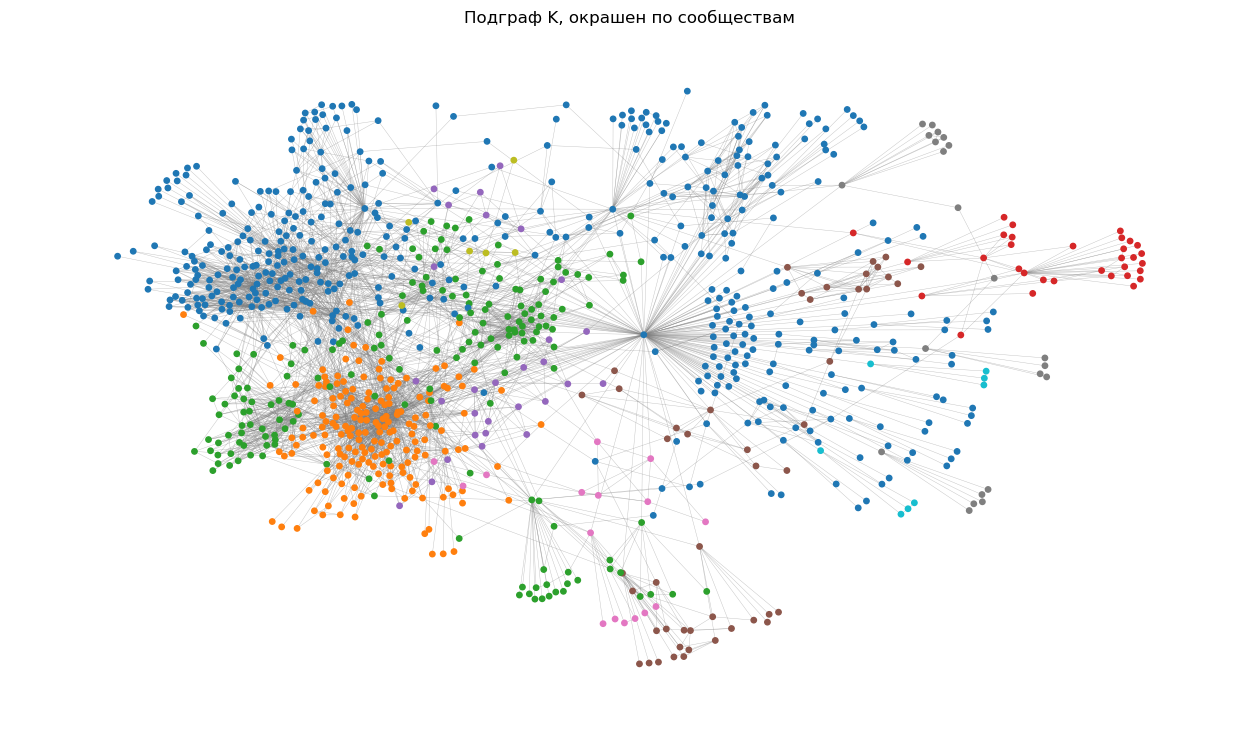

In [36]:
# здесь K — тот самый связный подграф на 1000 вершинах
nx_comms = list(greedy_modularity_communities(K))

node2comm = {}
for i, comm in enumerate(nx_comms):
    for n in comm:
        node2comm[n] = i

colors = [node2comm[n] for n in K.nodes()]

pos = nx.spring_layout(
    K,
    k=0.3,
    iterations=200,
    seed=42
)

plt.figure(figsize=(16, 9))
nx.draw_networkx_nodes(
    K, pos,
    node_color=colors,
    node_size=15,
    cmap="tab10"
)
nx.draw_networkx_edges(
    K, pos,
    width=0.3,
    alpha=0.5,  # полупрозрачные рёбра
    edge_color="gray"
)
plt.title("Подграф K, окрашен по сообществам")
plt.axis("off")
plt.show()